Use CV Validation to get the best hyperparameters for the LSH model:

- `bucketLength` $\in [0.5, 2.0]$ based on some small research 

- `numHashTables` $\in [1, 10]$ so the number of hash tables is not too large

- `approxSimilarityJoin` threshold $\in [0, 1.41]$ so the cosine angle can be at most $90 \degree$

---

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import collect_list, struct
from pyspark.ml.linalg import Vectors, SparseVector
from pyspark.sql import Row, DataFrame
from pyspark.ml.feature import Normalizer
from pyspark.ml.feature import BucketedRandomProjectionLSH
from pyspark.sql.functions import col
from pyspark.sql.functions import sum as sql_sum, col
from pyspark.sql.functions import coalesce, lit
from pyspark.ml.evaluation import RegressionEvaluator

import os
import json
import numpy as np
from functools import reduce
import time
import matplotlib.pyplot as plt

# Treat the data

In [2]:
spark = SparkSession.builder \
    .appName("ItemItemCF") \
    .config("spark.driver.memory", "6g") \
    .config("spark.executor.memory", "6g") \
    .getOrCreate()

data = spark.read.csv("data/100k.csv", header=True, inferSchema=True) \
            .select("userId", "movieId", "rating")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/17 23:21:50 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# get 10 folds of data
folds = data.randomSplit([0.1]*10, seed=42)

# Create functions automate the CV

In [4]:
def item_item_cf_similarities(ratings, bucketLength_in, numHashTables_in, threshold_in):
    # get the number of unique users
    num_users = ratings.select("userId").distinct().count()

    # create the sparse vector for movie function
    def to_sparse_vector(user_ratings, size):
        # Sort by userId to get strictly increasing indices
        sorted_pairs = sorted(user_ratings, key=lambda x: x.userId)
        indices = [x.userId - 1 for x in sorted_pairs]
        values = [x.rating for x in sorted_pairs]
        return Vectors.sparse(size, indices, values)

    # group by movieId and collect user ratings
    item_user = ratings.groupBy("movieId") \
        .agg(collect_list(struct("userId", "rating")).alias("user_ratings"))

    # convert that to a sparse vector
    item_vector_rdd = item_user.rdd.map(
        lambda row: Row(
            movieId=row["movieId"],
            features=to_sparse_vector(row["user_ratings"], num_users)
        )
    )

    # convert to DataFrame because of Normalizer (MLlib)
    item_vectors = spark.createDataFrame(item_vector_rdd)

    # normalizing with L2 (Euclidean) norm (p=2)
    normalizer = Normalizer(inputCol="features", outputCol="norm_features", p=2.0)
    normalized = normalizer.transform(item_vectors)

    # create the LSH model
    lsh = BucketedRandomProjectionLSH(
        inputCol="norm_features",
        outputCol="hashes",
        bucketLength=bucketLength_in,
        numHashTables=numHashTables_in
    )

    # fit the model
    lsh_model = lsh.fit(normalized)

    # get the approximate neighbors
    neighbors = lsh_model.approxSimilarityJoin(
        normalized,
        normalized,
        threshold=threshold_in,
        distCol="distance"
    ).filter(col("datasetA.movieId") < col("datasetB.movieId"))  # avoid bottom triangle (reverse + self)

    # convert the distance to cosine similarity
    neighbors_cosine = neighbors.withColumn(
        "cosine_sim",
        1 - (col("distance") ** 2) / 2
    ).select(
        col("datasetA.movieId").alias("movie_i"),
        col("datasetB.movieId").alias("movie_j"),
        "cosine_sim"
    )

    # add reverse pairs: (i,j) -> (i,j) and (j,i)
    reverse = neighbors_cosine.selectExpr("movie_j as movie_i", "movie_i as movie_j", "cosine_sim")
    similarities = neighbors_cosine.union(reverse)

    return similarities

In [5]:
def item_item_cf_predictions(ratings, similarities, test):
    # get the neighbors of the target movies
    test_with_ratings = test.alias("t") \
        .join(similarities.alias("s"), col("t.movieId") == col("s.movie_i")) \
        .join(ratings.alias("r"), (col("t.userId") == col("r.userId")) & (col("s.movie_j") == col("r.movieId"))) \
        .select(
            col("t.userId"),
            col("t.movieId").alias("target_movie"),
            col("s.movie_j").alias("neighbor_movie"),
            col("s.cosine_sim"),
            col("r.rating").alias("neighbor_rating")
        )

    # get the predicted rating
    predictions = test_with_ratings.groupBy("userId", "target_movie").agg(
        (sql_sum(col("cosine_sim") * col("neighbor_rating")) / sql_sum(col("cosine_sim"))).alias("pred_rating")
    )

    # join with the test set to get the actual rating
    final = predictions.alias("p").join(
        test.alias("t"),
        (col("p.userId") == col("t.userId")) & (col("p.target_movie") == col("t.movieId")),
        how="right"  # keep all test rows even if no prediction (no neighbors)
    ).select(
        col("t.userId"),
        col("t.movieId"),
        coalesce(col("p.pred_rating"), lit(3.0)).alias("pred_rating"),
        col("t.rating").alias("actual_rating")
    )

    return final

In [6]:
def item_item_cf_results(final):
    # RMSE
    evaluator = RegressionEvaluator(metricName="rmse", labelCol="actual_rating", predictionCol="pred_rating")
    rmse = evaluator.evaluate(final)

    # MAE
    mae_evaluator = RegressionEvaluator(metricName="mae", labelCol="actual_rating", predictionCol="pred_rating")
    mae = mae_evaluator.evaluate(final)

    return rmse, mae

In [7]:
def item_item_cf_cv(train, test, hyperparameters):
    bucketLength, numHashTables, threshold = hyperparameters

    similarities = item_item_cf_similarities(train, bucketLength, numHashTables, threshold)
    predictions = item_item_cf_predictions(train, similarities, test)
    rmse, mae = item_item_cf_results(predictions)
    
    return rmse, mae

# Applying the CV

In [8]:
# open the tuning.json file
if os.path.exists("tuning.json"):
    with open("tuning.json", 'r') as f:
        results = json.load(f)

else:
    results = {}

In [9]:
# get the hyperparameters search space
def sample_hyperparameters(n_samples):
    bucketLength = np.random.uniform(0.5, 2.0, size=n_samples).round(1)
    numHashTables = np.random.randint(1, 10, size=n_samples)
    threshold = np.random.uniform(0.1, 1.41, size=n_samples).round(1)

    return [(float(x), int(y), float(z)) for (x,y,z) in list(zip(bucketLength, numHashTables, threshold))]

In [ ]:
# apply the hyperparameter tuning
n_samples = 20
hyperparameters = sample_hyperparameters(n_samples)

# using partial CV for quicker tuning
n_validations = 5

# cycle through the hyperparameters
for i, hyperparameter in enumerate(hyperparameters):
    cvalidation = True

    if True:
        print("Bypassing hyperparameter tuning")
        break

    bucketLength, numHashTables, threshold = hyperparameter
    print(f"Combination {i+1}/{n_samples}: bucketLength={bucketLength}, numHashTables={numHashTables}, threshold={threshold}")

    if str(hyperparameter) in results:
        continue

    avg_rmse, avg_mae, avg_time = 0, 0, 0
    # cycle through the folds
    for validation in range(n_validations):

        try:
            # get the training folds
            training_folds = [folds[i] for i in range(len(folds)) if i not in [validation, 9]]
            train = reduce(DataFrame.unionByName, training_folds)

            # get the validation fold
            val = folds[validation]

            # run the item-item CF
            start = time.time()
            rmse, mae = item_item_cf_cv(train, val, hyperparameter)
            end = time.time()

            avg_rmse += rmse
            avg_mae += mae
            avg_time += round(end - start, 2)

        except Exception as e:
            print(f"Error in combination {i+1}/{n_samples} for validation {validation}: {e}")
            cvalidation = False
            break

    # save the results
    if cvalidation:
        results[str(hyperparameter)] = {
            "bucketLength": bucketLength,
            "numHashTables": numHashTables,
            "threshold": threshold,
            "n_validations": n_validations,
            "rmse": avg_rmse / n_validations,
            "mae": avg_mae / n_validations,
            "time": avg_time / n_validations
        }

Bypassing hyperparameter tuning


In [11]:
with open("tuning.json", 'w') as f:
    json.dump(results, f, indent=4)

# Choosing the best hyperparameters

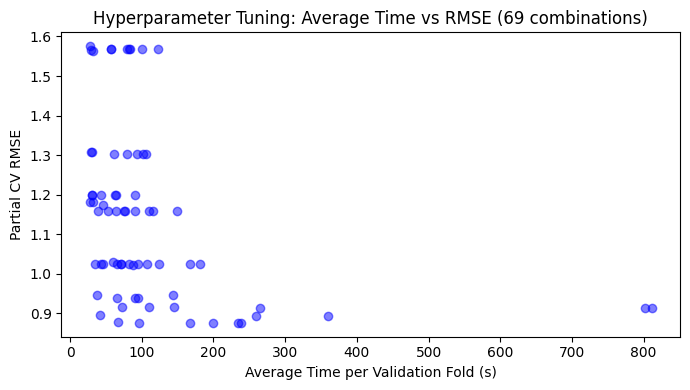

In [19]:
with open("tuning.json", 'r') as f:
    results = json.load(f)

plt.figure(figsize=(7, 4))
plt.title(f"Hyperparameter Tuning: Average Time vs RMSE ({len(results)} combinations)")
plt.xlabel("Average Time per Validation Fold (s)")
plt.ylabel("Partial CV RMSE")

for key, value in results.items():
    plt.scatter(value["time"], value["rmse"], c='blue', alpha=0.5)

plt.tight_layout()
plt.show()

In [30]:
sorted([(x, round(results[x]["rmse"], 3), round(results[x]["time"])) for x in results], key=lambda t: t[1])[:10]

[('(0.8, 9, 1.2)', 0.876, 234),
 ('(1.3, 8, 1.2)', 0.876, 238),
 ('(0.9, 4, 1.2)', 0.876, 97),
 ('(0.7, 7, 1.2)', 0.876, 168),
 ('(1.9, 7, 1.2)', 0.876, 199),
 ('(0.8, 3, 1.2)', 0.878, 67),
 ('(1.4, 5, 1.3)', 0.894, 259),
 ('(0.7, 6, 1.3)', 0.894, 359),
 ('(2.0, 1, 1.2)', 0.897, 41),
 ('(0.9, 5, 1.4)', 0.914, 811)]

the best hyperparameters for the LSH model might be one of the following:

- ('(0.8, 3, 1.2)', 0.878, 67)

- ('(2.0, 1, 1.2)', 0.897, 41),

- ('(0.6, 3, 0.9)', 0.946, 37),